# Import Package dan Data Collecting

In [1]:
# pip install pmdarima

In [1]:
#======= Modelling =====
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima.utils import ndiffs

#======= Pandas confiq =====
import pandas as pd

#==== Numpy ======
import numpy as np
from math import sqrt

#===== Visualization =====
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

import warnings
warnings.filterwarnings('ignore')

In [2]:
customer = pd.read_csv('Case Study - Customer.csv', sep=';')
product = pd.read_csv('Case Study - Product.csv', sep=';')
store = pd.read_csv('Case Study - Store.csv', sep=';')
transaction = pd.read_csv('Case Study - Transaction.csv', sep=';')

# Data Preprocessing

In [3]:
transaction = transaction.astype({
    'Price':'float',
    'TotalAmount':'float',
    'Date':'datetime64'
})

transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   TransactionID  5020 non-null   object        
 1   CustomerID     5020 non-null   int64         
 2   Date           5020 non-null   datetime64[ns]
 3   ProductID      5020 non-null   object        
 4   Price          5020 non-null   float64       
 5   Qty            5020 non-null   int64         
 6   TotalAmount    5020 non-null   float64       
 7   StoreID        5020 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 313.9+ KB


In [4]:
product = product.astype({
    'price':'float'
})

product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   productid  10 non-null     object 
 1   product    10 non-null     object 
 2   price      10 non-null     float64
dtypes: float64(1), object(2)
memory usage: 368.0+ bytes


In [5]:
df = transaction.merge(product,how='left', left_on='ProductID', right_on='productid')
df.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID,productid,product,price
0,TR11369,328,2022-01-01,P3,7500.0,4,30000.0,12,P3,Crackers,7500.0
1,TR16356,165,2022-01-01,P9,10000.0,7,70000.0,1,P9,Yoghurt,10000.0
2,TR1984,183,2022-01-01,P1,8800.0,4,35200.0,4,P1,Choco Bar,8800.0
3,TR35256,160,2022-01-01,P1,8800.0,7,61600.0,4,P1,Choco Bar,8800.0
4,TR41231,386,2022-01-01,P9,10000.0,1,10000.0,4,P9,Yoghurt,10000.0


In [6]:
df_reg = df.groupby(['Date']).agg({'Qty':'sum'})
df_reg

,Qty
Date,
2022-01-01,49
2022-01-02,50
2022-01-03,76
2022-01-04,98
2022-01-05,67
...,...
2022-12-27,70
2022-12-28,68
2022-12-29,42


# Exploratory Data Analysis

<AxesSubplot:xlabel='Qty'>

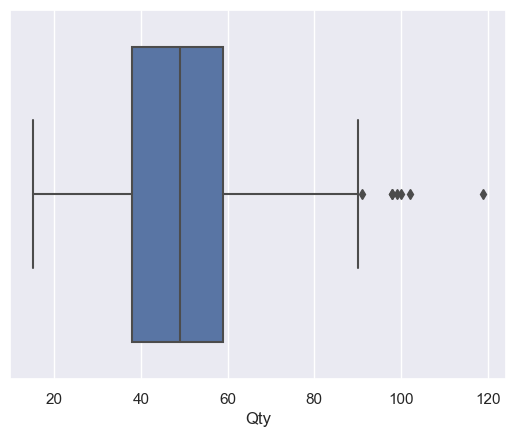

In [7]:
sns.boxplot(x=df_reg['Qty'])

<AxesSubplot:xlabel='Date'>

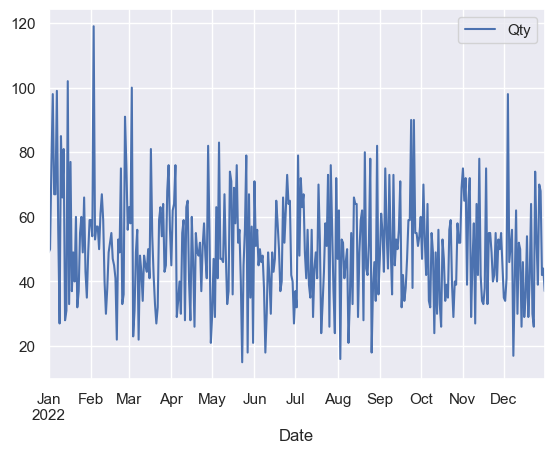

In [8]:
df_reg.plot()

Dari visualisasi diatas, data Qty tidak terdapat pola trend naik maupun turun dan tidak terdapat juga seasonality pada Qty. Dat Qty cederung memiliki pola tetap atau stasioner

**CEK STATIONARY**

In [9]:
def ad_test(data):
    dftest = adfuller(data, autolag='AIC')
    print('1. ADF : ',dftest[0])
    print('2. P-Value : ',dftest[1])
    print('3. Num of Lags : ',dftest[2])
    print('4. Num of observation used for ADF regression and critical value calculation : ',dftest[3])
    print('5. Critical value')
    for key, val in dftest[4].items():
        print('\t',key,':',val)

ad_test(df['Qty'])

1. ADF :  -70.20851928088037
2. P-Value :  0.0
3. Num of Lags :  0
4. Num of observation used for ADF regression and critical value calculation :  5019
5. Critical value
	 1% : -3.4316535759402753
	 5% : -2.8621160400844468
	 10% : -2.567076626752987


Uji hipotesis apakah data tersebut stationer atau tidak
- H0 : data tidak stationer
- H1 : data statisoner
    
Jika
- p-value > 0.05 maka gagal tolak H0
- p-value <= 0.05 maka tolak H0

Nilai p-value = 0, maka kesimpulannya adalah data tersebut stationer

**AUTOCORRELATION FUNCTION**

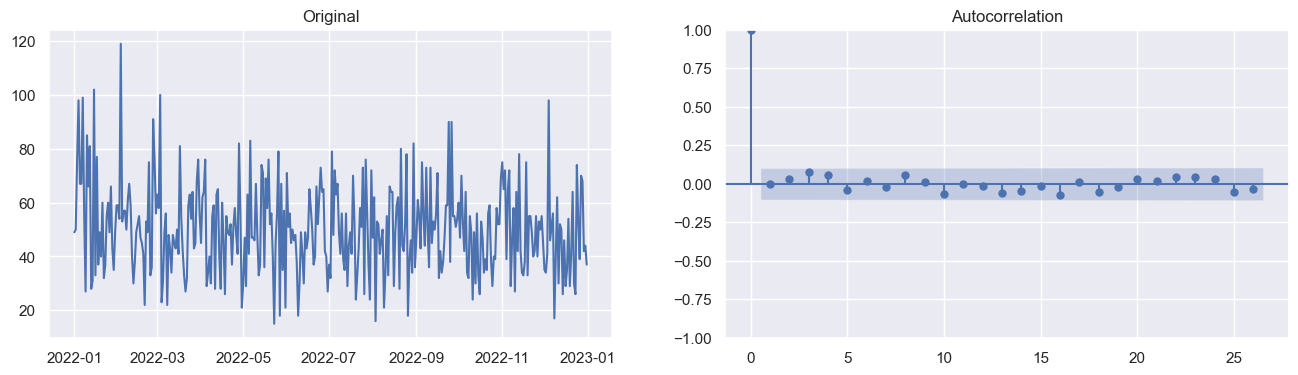

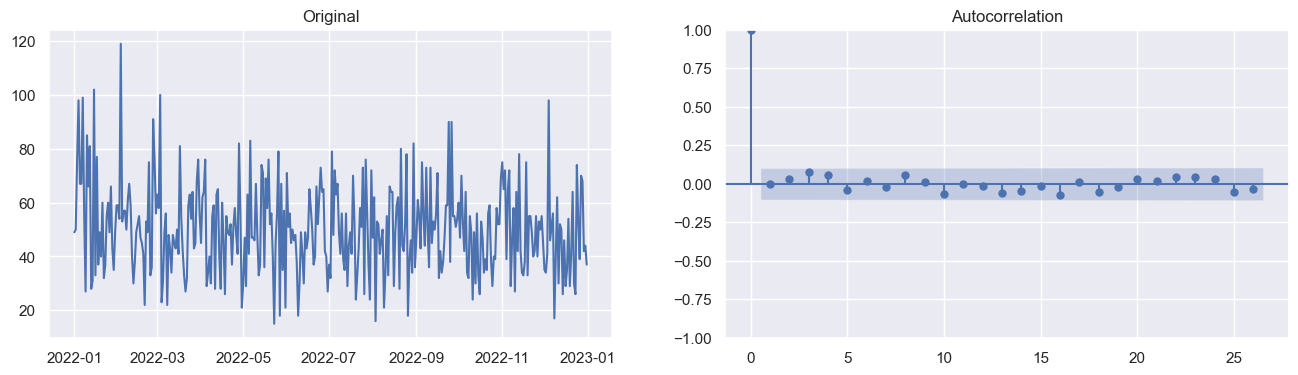

In [10]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,4))

ax1.plot(df_reg['Qty'])
ax1.set_title('Original')
plot_acf(df_reg['Qty'], ax=ax2)

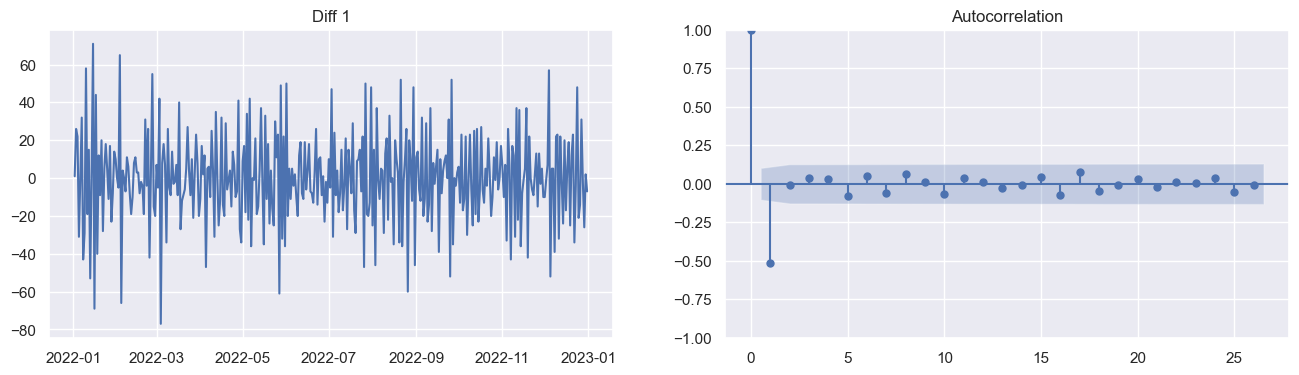

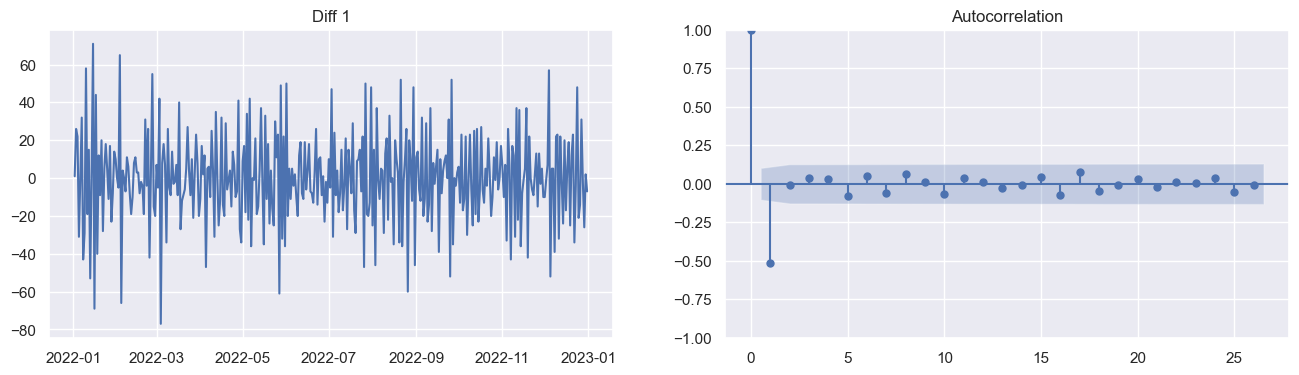

In [11]:
diff = df_reg['Qty'].diff().dropna()

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,4))

ax1.plot(diff)
ax1.set_title('Diff 1')
plot_acf(diff, ax=ax2)

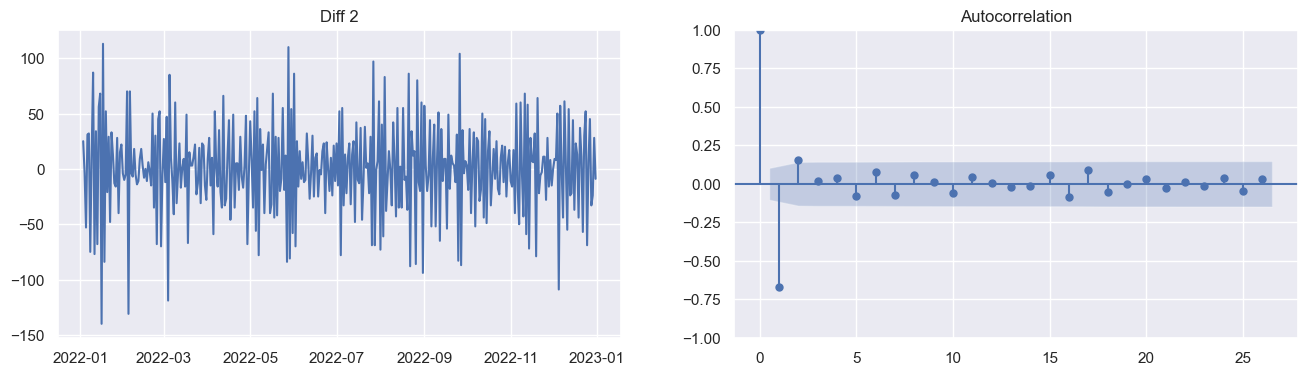

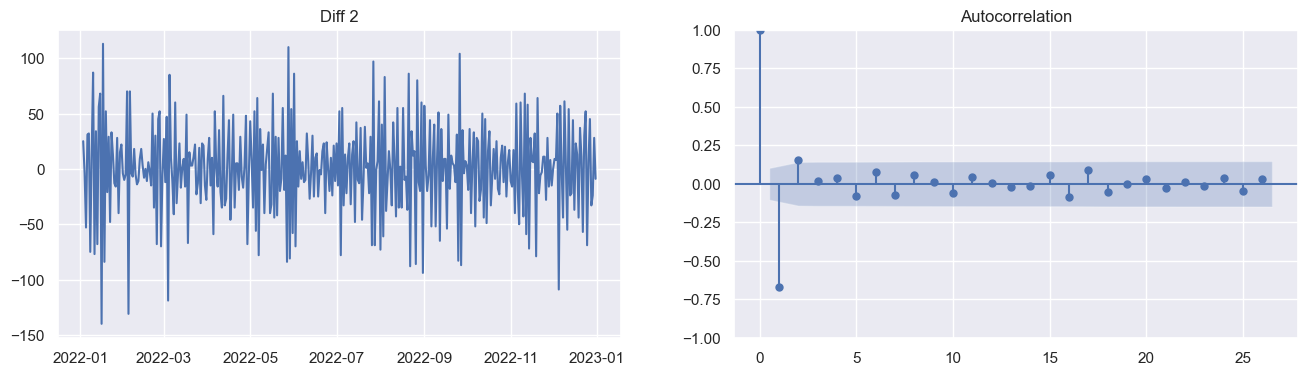

In [12]:
diff = df_reg['Qty'].diff().diff().dropna()

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,4))

ax1.plot(diff)
ax1.set_title('Diff 2')
plot_acf(diff, ax=ax2)

**Nilai D**

In [13]:
ndiffs(df_reg['Qty'], test='adf')

0

Niali D merupakan nilai yang menunjukkan data tersebut stationer atau tidak, jika 0 artinya data tersebut stationer begitupun sebaliknya 

**Nilai P**

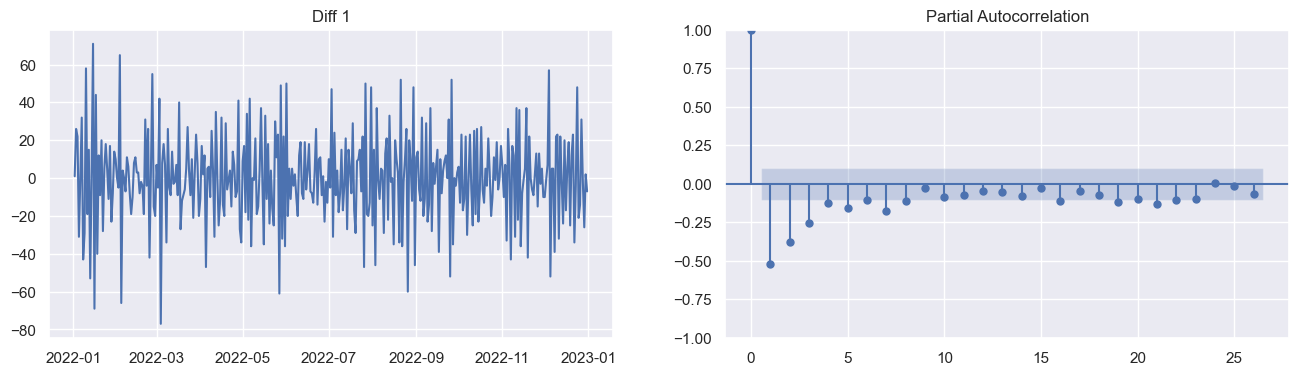

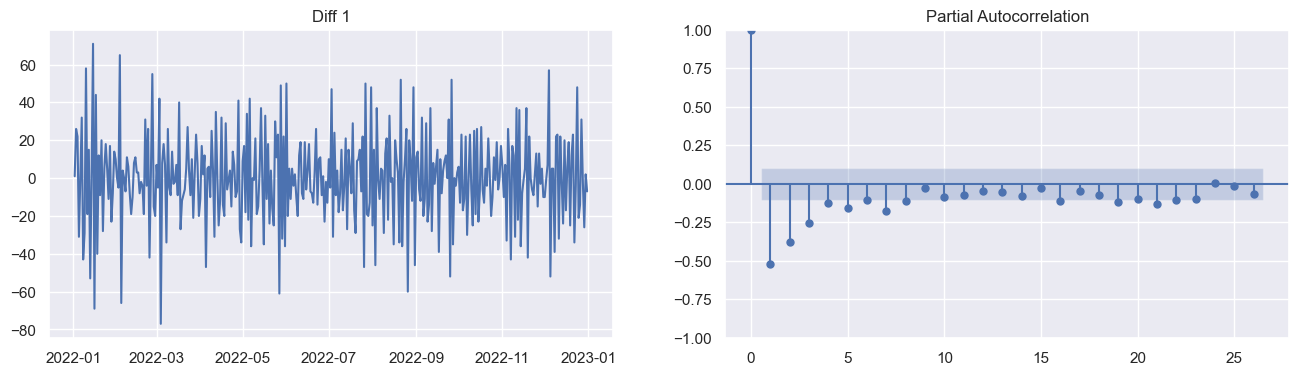

In [14]:
diff = df_reg['Qty'].diff().dropna()

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,4))

ax1.plot(diff)
ax1.set_title('Diff 1')
plot_pacf(diff, ax=ax2)

Untuk mendapatkan nilai P secara manual, kita perlu melakukan cek partial autocorrelation yang dimana jika terdapat nilai yang melebihi batas biru, maka nilai tersebut merupakan nilai kandidat dari nilai P

**Nilai Q**

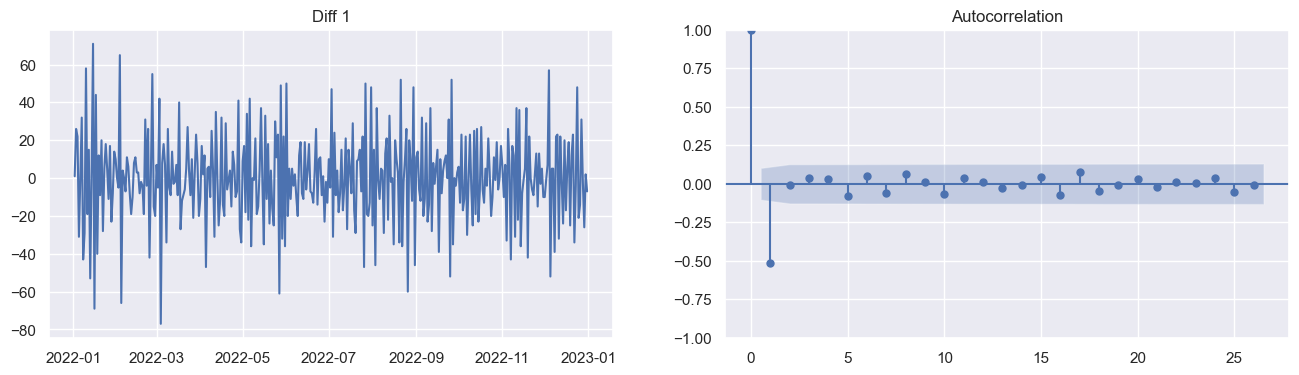

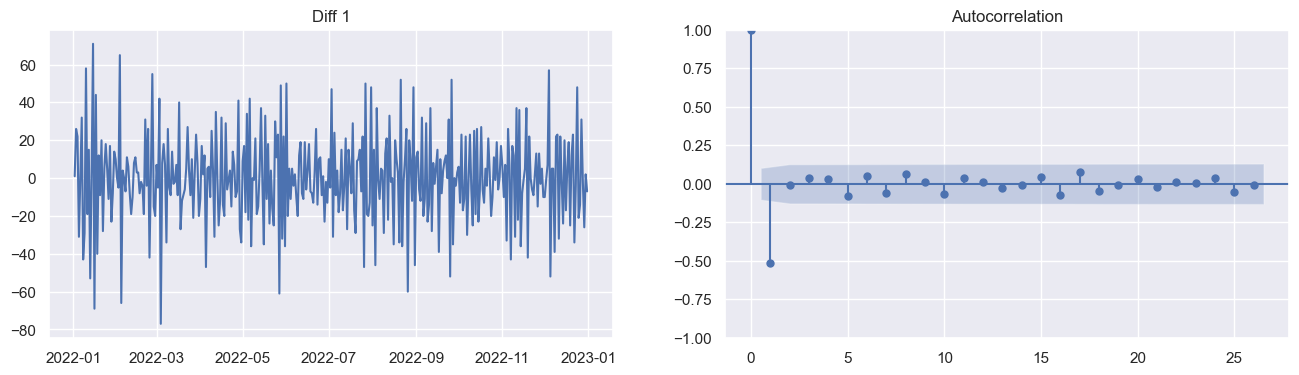

In [15]:
diff = df_reg['Qty'].diff().dropna()

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,4))

ax1.plot(diff)
ax1.set_title('Diff 1')
plot_acf(diff, ax=ax2)

Untuk mendapatkan nilai Q secara manual, kita perlu melakukan cek autocorrelation yang dimana jika terdapat nilai yang melebihi batas biru, maka nilai tersebut merupakan nilai kandidat dari nilai Q

**MENCARI P,D,Q MENGGUNAKAN AUTO ARIMA**

In [16]:
stepwise_fit = auto_arima(df_reg['Qty'], trace=True, suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=3098.997, Time=1.10 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=3094.267, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=3096.267, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=3096.267, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3933.778, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=3098.260, Time=0.23 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 1.722 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  365
Model:                        SARIMAX   Log Likelihood               -1545.134
Date:                Mon, 11 Sep 2023   AIC                           3094.267
Time:                        19:17:07   BIC                           3102.067
Sample:                    01-01-2022   HQIC                          3097.367
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     50.1260      0.937     53.483      0.000      48.289      51.963
sigma2       278.2745     19.201     14.493      0.000     240.642     315.907
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                27.78
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.67   Skew:                             0.59
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Modelling

**MODELLING MENGGUNAKAN ARIMA**

MSE:  257.03818245165485
RMSE:  16.03241037560026


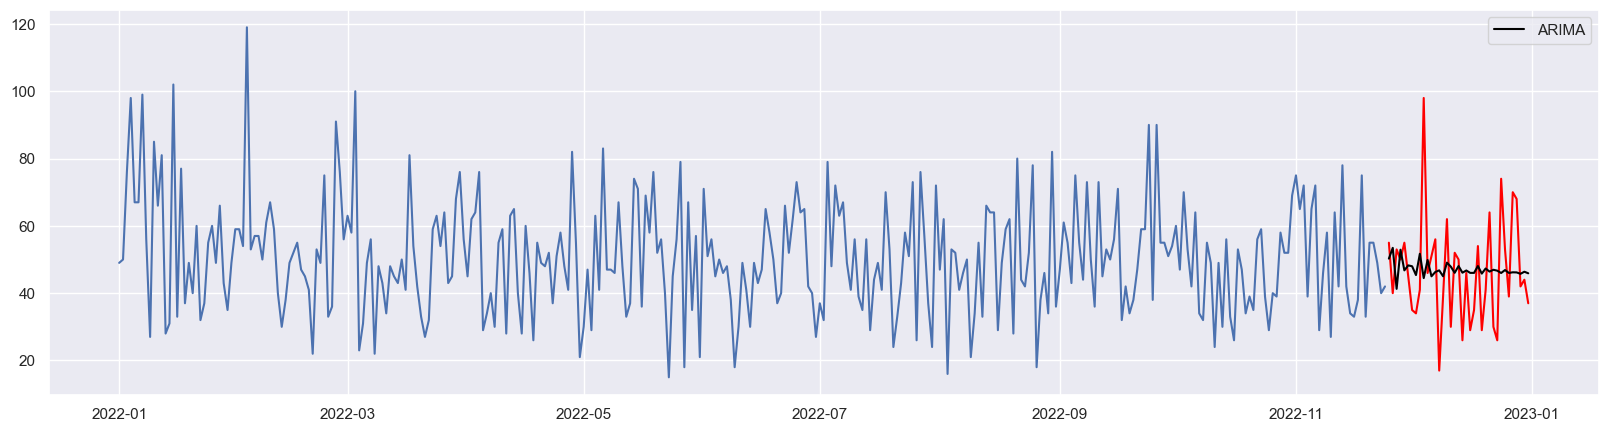

In [27]:
# Select ratio
ratio = 0.9
 
total_rows = df_reg.shape[0]
train_size = int(total_rows*ratio)
 
# Split data into test and train
train = df_reg[:train_size]
test = df_reg[train_size:]

y = train['Qty']

model = ARIMA(y, order=(22,2,1))
model = model.fit()

y_pred = model.get_forecast(len(test))

y_pred_df = y_pred.conf_int()
y_pred_df['predictions'] = model.predict(start=y_pred_df.index[0], end=y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df['predictions']
# eval(test['Qty'], y_pred_out)
mse = mean_squared_error(test['Qty'], y_pred_out)
print('MSE: ',mse)
rmse = math.sqrt(mse)
print('RMSE: ',rmse)

plt.figure(figsize=(20,5))
plt.plot(train['Qty'])
plt.plot(test['Qty'], color='red')
plt.plot(y_pred_out, color='black', label='ARIMA')
plt.legend()